## Corona progression in The Netherlands

In [39]:
import csv
import pandas as pd
import re

DATE = "Date_of_report"
DEAD = "Deceased"
HOSPITALIZED = "Hospital_admission"
INFILENAME = "corona-nl-totals.csv"
INFECTED = "Total_reported"
URL = "https://data.rivm.nl/covid-19/COVID-19_aantallen_gemeente_cumulatief.csv"

def summarizeDate(date):
    return(re.sub(r"-","",date.split()[0]))

def readData():
    try:
        df = pd.read_csv(URL,sep=";")
        dfGroups = df.groupby(DATE)
        lastDead,lastHospitalized,lastInfected = 0,0,0
        data = {}
        for date,group in dfGroups:
            date = summarizeDate(date)
            dead = sum(group[DEAD])
            hospitalized = sum(group[HOSPITALIZED])
            infected = sum(group[INFECTED])
            data[date] = {INFECTED:infected-lastInfected,HOSPITALIZED:hospitalized-lastHospitalized,DEAD:dead-lastDead}
            lastDead,lastHospitalized,lastInfected = dead,hospitalized,infected
        pd.DataFrame.from_dict(data).to_csv(INFILENAME)
        print(f"stored data in file {INFILENAME}")
    except: 
        data = pd.read_csv(INFILENAME,index_col=0).T.to_dict()
        print(f"read data from file {INFILENAME}")
    return(data)
    
data = readData()
print(f"updated until {list(data.keys())[-1]} ({list(data.values())[-1][INFECTED]})")

stored data in file corona-nl-totals.csv
updated until 20220107 (34872)


In [40]:
def combine(listIn,maxCount):
    listOut = []
    for i in range(0,len(listIn)):
        total = 0
        count = 0
        for j in range(i,i-maxCount,-1): 
            if j >= 0:
                total += listIn[j]
                count += 1
        listOut.append(total/count)
    return(listOut)

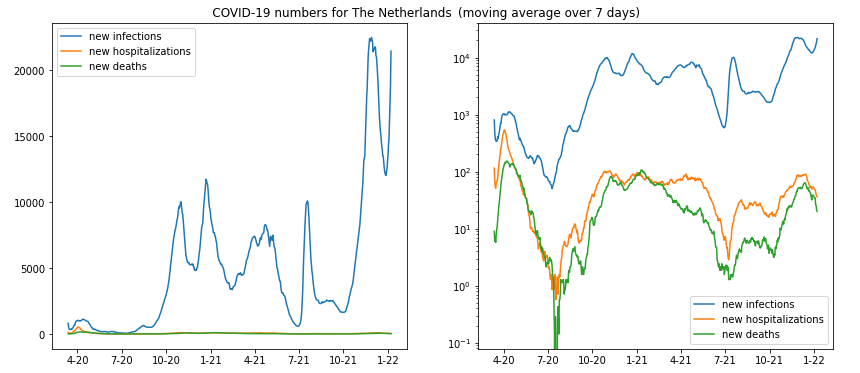

In [41]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

DATEPATTERN = "%Y%m%d"
PLOTFILENAME = "corona-nl.png"
WEEKLENGTH = 7
MAXDATE = "99999999"

def visualize(data):
    x = [datetime.datetime.strptime(str(date),DATEPATTERN) for date in data if date < MAXDATE]
    infected = combine([data[date][INFECTED] for date in data if date < MAXDATE],WEEKLENGTH)
    hospitalized = combine([data[date][HOSPITALIZED] for date in data if date < MAXDATE],WEEKLENGTH)
    dead = combine([data[date][DEAD] for date in data if date < MAXDATE],WEEKLENGTH)

    plt.subplots(figsize=(14,6))
    ax = plt.subplot(121)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%-m-%-y"))
    plt.plot_date(x,infected,fmt="-",label="new infections")
    plt.plot_date(x,hospitalized,fmt="-",label="new hospitalizations")
    plt.plot_date(x,dead,fmt="-",label="new deaths")
    plt.legend()
    plt.title("                                                     COVID-19 numbers for The Netherlands")
    ax = plt.subplot(122)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%-m-%-y"))
    plt.yscale("log")
    plt.plot_date(x,infected,fmt="-",label="new infections")
    plt.plot_date(x,hospitalized,fmt="-",label="new hospitalizations")
    plt.plot_date(x,dead,fmt="-",label="new deaths")
    plt.legend()
    plt.title("(moving average over 7 days)                                                       ")
    plt.savefig(PLOTFILENAME)
    plt.show()
    last_week = [int(x) for x in infected[-8:]], [int(x) for x in hospitalized[-8:]], [int(x) for x in dead[-8:]]
    return x, infected, hospitalized, dead, last_week
    
x, infected, hospitalized, dead, last_week = visualize(data)

## Numbers of last week

In [42]:
print(f"infected: {last_week[0]}\nhospitalized: {last_week[1]}\ndead: {last_week[2]}")

infected: [13169, 13598, 14397, 14841, 16183, 17437, 18837, 21432]
hospitalized: [52, 50, 48, 48, 44, 39, 37, 36]
dead: [37, 35, 34, 34, 26, 25, 21, 20]


## Estimation of infection peak in first wave

In [23]:
def get_max(x, data_part, lowest, highest):
    max_value = -1
    max_id = None
    for i in range(0, len(data_part)):
        if x[i] >= lowest and x[i] <= highest and data_part[i] > max_value:
            max_value = data_part[i]
            max_id = x[i]
    return max_value, max_id    

In [33]:
peak2_max_infected, peak2_date_infected = get_max(x, infected, datetime.datetime(2020, 10, 1, 0, 0), datetime.datetime(2020, 11, 30, 23, 59))
peak2_max_hospitalized, peak2_date_hospitalized = get_max(x, hospitalized, datetime.datetime(2020, 10, 1, 0, 0), datetime.datetime(2020, 11, 30, 23, 59))
peak1_max_hospitalized, peak1_date_hospitalized = get_max(x, hospitalized, datetime.datetime(2020,  3, 1, 0, 0), datetime.datetime(2020,  5, 31, 23, 59))
print(f"predicted infected peak 1: {peak2_max_infected * peak1_max_hospitalized / peak2_max_hospitalized:.0f};", 
      f"hospitalized peak 1: {peak1_max_hospitalized:.0f} ({peak1_date_hospitalized.strftime('%Y-%m-%d')});", 
      f"infected peak 2: {peak2_max_infected:.0f} ({peak2_date_infected.strftime('%Y-%m-%d')});", 
      f"hospitalized peak 2: {peak2_max_hospitalized:.0f} ({peak2_date_hospitalized.strftime('%Y-%m-%d')})")

predicted infected peak 1: 52518; hospitalized peak 1: 541 (2020-04-03); infected peak 2: 10018 (2020-10-31); hospitalized peak 2: 103 (2020-11-05)
